## Implementation of the paper: "The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks" on ResNet152 Image Classification Model

# Authors: Yusuf ASLAN, Ali Esad UĞUR, Feray Lina YENCE
# Date: 26.05.2023

# Importing Necessary Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.applications import ResNet50, ResNet152
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses

# Lottery Ticket Hypothesis Algorithm to Prune Models

In [2]:
def iterative_pruning_lottery_ticket(x_train, y_train, x_val, y_val, num_iterations, prune_percentage, model):    
    # Early Stopping criterion will be used in model fitting
    # early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True, min_delta=0.001, start_from_epoch=20)

    percentage = prune_percentage
    weight_rate = 100
    history_list = []

    for iteration in range(num_iterations):
      weight_rate = weight_rate - (weight_rate * (prune_percentage/100))
      percentage = 100 - weight_rate
    
      print(f"Iteration {iteration+1} / {num_iterations} ")
      # Identify important weights based on magnitudes
      weights = model.get_weights()
      magnitudes = [np.abs(w).flatten() for w in weights]
      importance = np.concatenate(magnitudes)
      threshold = np.percentile(importance, percentage)
    

      # Prune the least important weights
      pruned_weights = [np.where(np.abs(w) < threshold, 0, w) for w in weights]
      model.set_weights(pruned_weights)
    
      # fine-tune the pruned model
      history = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val))
      history_list.append(history)

    return model, history_list

# Loading and preparing MNIST Dataset 

In [3]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)
x_val = x_train[-2000:,:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:,:]
y_train = y_train[:-2000]

# Creating and Training Base Model : ResNet152

In [4]:
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True, min_delta=0.001, start_from_epoch=20)

base_model = ResNet152(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
for layer in base_model.layers:
  layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(1000, activation='relu')(x)
predictions = Dense(10, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
# Train the model
history1 = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val))


234698864/234698864 [==============================] - 7s 0us/step
Epoch 1/20
454/454 [==============================] - 39s 47ms/step - loss: 1.0063 - accuracy: 0.6718 - val_loss: 0.6245 - val_accuracy: 0.8125
Epoch 2/20
454/454 [==============================] - 17s 38ms/step - loss: 0.6411 - accuracy: 0.7946 - val_loss: 0.5048 - val_accuracy: 0.8460
Epoch 3/20
454/454 [==============================] - 18s 40ms/step - loss: 0.5511 - accuracy: 0.8229 - val_loss: 0.3680 - val_accuracy: 0.8960
Epoch 4/20
454/454 [==============================] - 18s 39ms/step - loss: 0.4934 - accuracy: 0.8410 - val_loss: 0.3639 - val_accuracy: 0.9000
Epoch 5/20
454/454 [==============================] - 19s 41ms/step - loss: 0.4546 - accuracy: 0.8525 - val_loss: 0.3262 - val_accuracy: 0.9035
Epoch 6/20
454/454 [==============================] - 19s 41ms/step - loss: 0.4230 - accuracy: 0.8628 - val_loss: 0.3146 - val_accuracy: 0.9060
Epoch 7/20
454/454 [==============================] - 19s 42ms/step -

# One-Shot Pruning Approach of Lottery Ticket Hypothesis (We have pruned 20% weights)

In [5]:
# Copying the model to compare original and pruned model in future
pruned_model = clone_model(model)

# Compile the model
pruned_model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

# Running Lotttery Ticket Hypothesis on the model
pruned_model, history2 = iterative_pruning_lottery_ticket(x_train, y_train, x_val, y_val, 1, 20, pruned_model)

Iteration 1 / 1 
Epoch 1/20
454/454 [==============================] - 31s 48ms/step - loss: 1.4628 - accuracy: 0.5768 - val_loss: 0.7270 - val_accuracy: 0.8515
Epoch 2/20
454/454 [==============================] - 19s 42ms/step - loss: 0.6525 - accuracy: 0.8138 - val_loss: 0.4163 - val_accuracy: 0.9030
Epoch 3/20
454/454 [==============================] - 19s 42ms/step - loss: 0.4832 - accuracy: 0.8567 - val_loss: 0.3227 - val_accuracy: 0.9150
Epoch 4/20
454/454 [==============================] - 19s 43ms/step - loss: 0.4112 - accuracy: 0.8757 - val_loss: 0.2762 - val_accuracy: 0.9265
Epoch 5/20
454/454 [==============================] - 19s 41ms/step - loss: 0.3663 - accuracy: 0.8887 - val_loss: 0.2595 - val_accuracy: 0.9320
Epoch 6/20
454/454 [==============================] - 19s 43ms/step - loss: 0.3405 - accuracy: 0.8961 - val_loss: 0.2254 - val_accuracy: 0.9410
Epoch 7/20
454/454 [==============================] - 19s 42ms/step - loss: 0.3151 - accuracy: 0.9040 - val_loss: 0.213

## Plotting Train and Test accuracies of Original and 20% pruned models

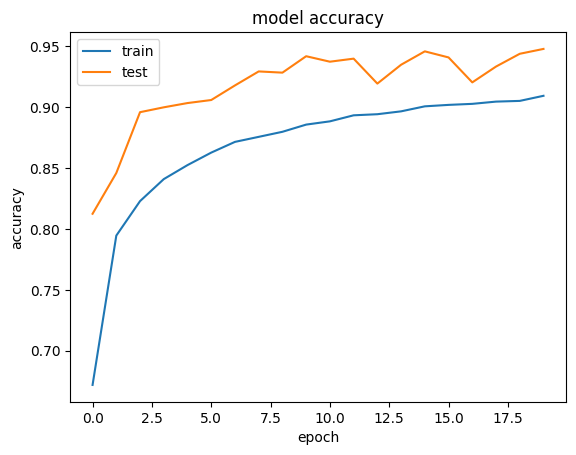

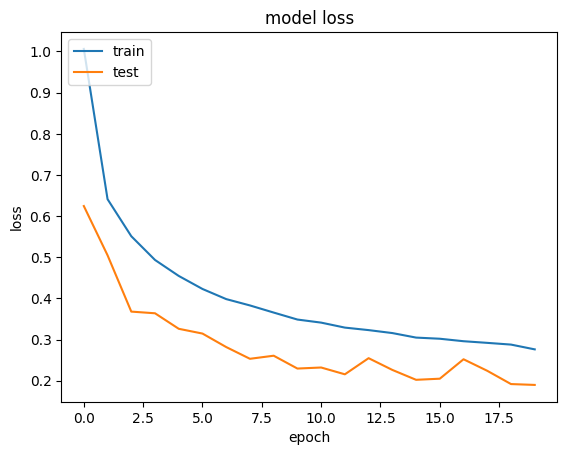

In [6]:
# Plots for model itself
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

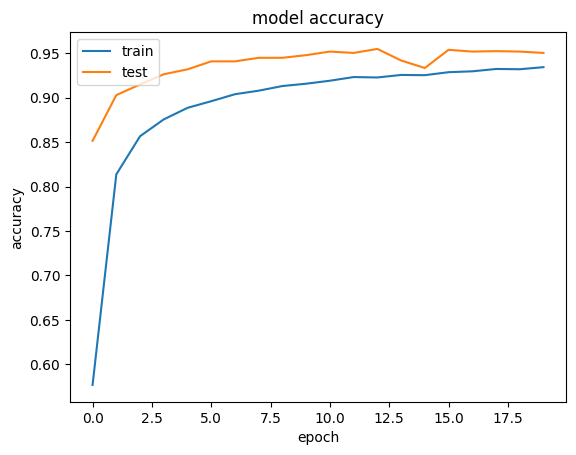

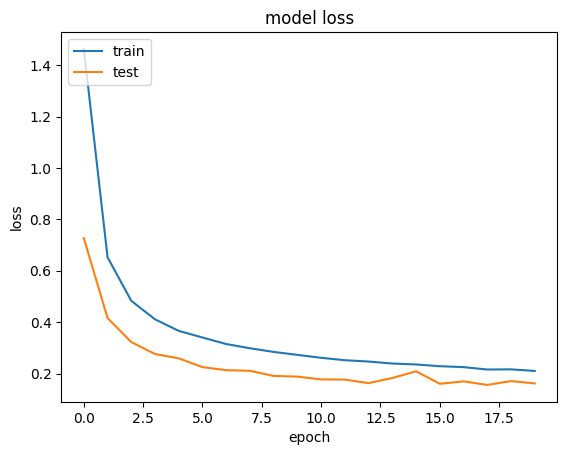

In [7]:
# Plots for pruned model (one-shot)

# Summarize history for accuracy
plt.plot(history2[0].history['accuracy'])
plt.plot(history2[0].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history2[0].history['loss'])
plt.plot(history2[0].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Comparing Train and Test accuracies of Original and 20% pruned models

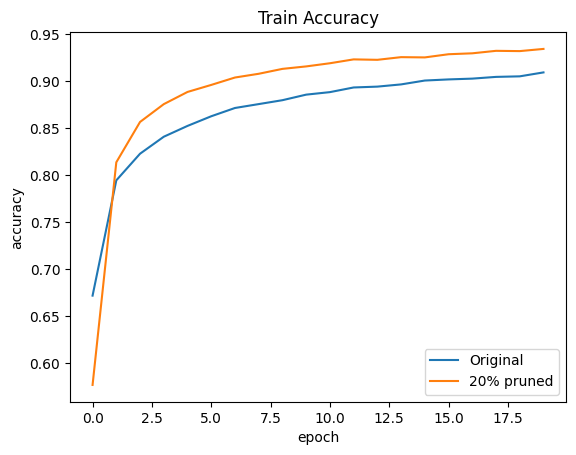

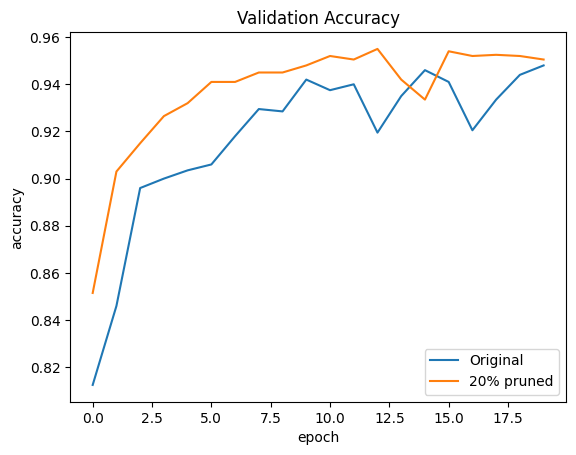

In [8]:
# Compare Train accuracies of original model and 20% pruning
plt.plot(history1.history['accuracy'])
plt.plot(history2[0].history['accuracy'])
plt.title('Train Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Original', '20% pruned'], loc='lower right')
plt.show()

# Compare Validation accuracies of original model and 20% pruning
plt.plot(history1.history['val_accuracy'])
plt.plot(history2[0].history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Original', '20% pruned'], loc='lower right')
plt.show()

## Printing Maximum Train and Test accuracies of Original and 20% pruned models

In [9]:
# Best train accuracy of original model
max_tr_acc_original = max(history1.history["accuracy"])
print(f"Highest Train Accuracy of original Resnet152 Model: {max_tr_acc_original}") 

# Best train accuracy of 20% pruned model
max_tr_acc_pruned20 = max(history2[0].history["accuracy"])
print(f"Highest Train Accuracy of 20% Pruned Resnet152 Model: {max_tr_acc_pruned20}") 


Highest Train Accuracy of original Resnet152 Model: 0.909465491771698
Highest Train Accuracy of 20% Pruned Resnet152 Model: 0.9344655275344849


In [10]:
# Best validation accuracy of original model
max_val_acc_original = max(history1.history["val_accuracy"])
print(f"Highest Validation Accuracy of original Resnet152 Model: {max_val_acc_original}") 

# Best validation accuracy of 20% pruned model
max_val_acc_pruned20 = max(history2[0].history["val_accuracy"])
print(f"Highest Validation Accuracy of 20% Pruned Resnet152 Model: {max_val_acc_pruned20}") 

Highest Validation Accuracy of original Resnet152 Model: 0.9480000138282776
Highest Validation Accuracy of 20% Pruned Resnet152 Model: 0.9549999833106995


# One-Shot Pruning Approach of Lottery Ticket Hypothesis (We have pruned 50% weights)

## Plotting and printing necessary informations

Iteration 1 / 1 
Epoch 1/20
454/454 [==============================] - 31s 45ms/step - loss: 1.3924 - accuracy: 0.5930 - val_loss: 0.6632 - val_accuracy: 0.8475
Epoch 2/20
454/454 [==============================] - 18s 40ms/step - loss: 0.6685 - accuracy: 0.7994 - val_loss: 0.4302 - val_accuracy: 0.8865
Epoch 3/20
454/454 [==============================] - 18s 39ms/step - loss: 0.5195 - accuracy: 0.8382 - val_loss: 0.3433 - val_accuracy: 0.9060
Epoch 4/20
454/454 [==============================] - 18s 40ms/step - loss: 0.4446 - accuracy: 0.8603 - val_loss: 0.2831 - val_accuracy: 0.9255
Epoch 5/20
454/454 [==============================] - 18s 40ms/step - loss: 0.3982 - accuracy: 0.8752 - val_loss: 0.2520 - val_accuracy: 0.9340
Epoch 6/20
454/454 [==============================] - 18s 40ms/step - loss: 0.3627 - accuracy: 0.8865 - val_loss: 0.2450 - val_accuracy: 0.9320
Epoch 7/20
454/454 [==============================] - 18s 40ms/step - loss: 0.3398 - accuracy: 0.8937 - val_loss: 0.214

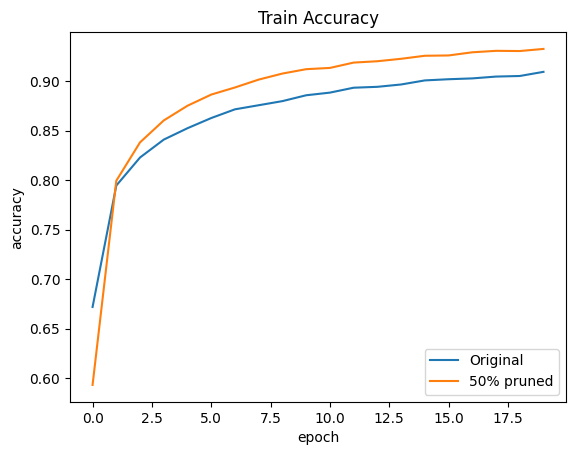

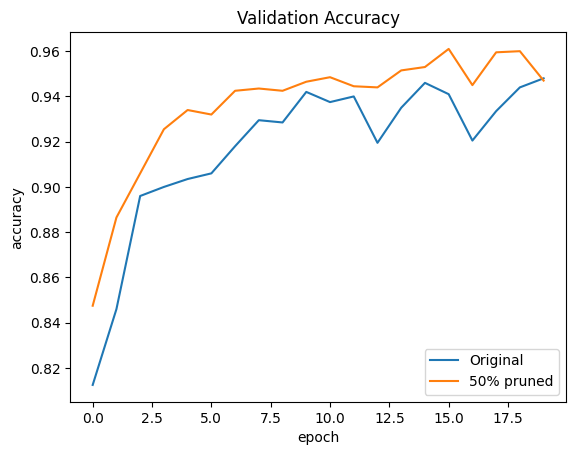

Highest Train Accuracy of original Resnet152 Model: 0.909465491771698
Highest Train Accuracy of 50% Pruned Resnet152 Model: 0.9326379299163818
Highest Validation Accuracy of original Resnet152 Model: 0.9480000138282776
Highest Validation Accuracy of 50% Pruned Resnet152 Model: 0.9610000252723694


In [16]:
# Copying the model to compare original and pruned model in future
pruned_model = clone_model(model)

# Compile the model
pruned_model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

# Running Lotttery Ticket Hypothesis on the model
pruned_model, history2 = iterative_pruning_lottery_ticket(x_train, y_train, x_val, y_val, 1, 50, pruned_model)

# Compare Train accuracies of original model and 50% pruning
plt.plot(history1.history['accuracy'])
plt.plot(history2[0].history['accuracy'])
plt.title('Train Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Original', '50% pruned'], loc='lower right')
plt.show()

# Compare Validation accuracies of original model and 50% pruning
plt.plot(history1.history['val_accuracy'])
plt.plot(history2[0].history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Original', '50% pruned'], loc='lower right')
plt.show()

# Best train accuracy of original model
max_tr_acc_original = max(history1.history["accuracy"])
print(f"Highest Train Accuracy of original Resnet152 Model: {max_tr_acc_original}") 

# Best train accuracy of 50% pruned model
max_tr_acc_pruned50 = max(history2[0].history["accuracy"])
print(f"Highest Train Accuracy of 50% Pruned Resnet152 Model: {max_tr_acc_pruned50}") 


# Best validation accuracy of original model
max_val_acc_original = max(history1.history["val_accuracy"])
print(f"Highest Validation Accuracy of original Resnet152 Model: {max_val_acc_original}") 

# Best validation accuracy of 50% pruned model
max_val_acc_pruned50 = max(history2[0].history["val_accuracy"])
print(f"Highest Validation Accuracy of 50% Pruned Resnet152 Model: {max_val_acc_pruned50}") 

# Iterative Pruning Approach of Lottery Ticket Hypothesis (7 iterations until we have almost 20% weights)

## Training Models and Getting Results

In [11]:
# Copying the model to compare original and pruned model in future
pruned_model2 = clone_model(model)

# Compile the model
pruned_model2.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

# Running Lotttery Ticket Hypothesis on the model
pruned_model2, history3 = iterative_pruning_lottery_ticket(x_train, y_train, x_val, y_val, 7, 20, pruned_model2)

Iteration 1 / 7 
Epoch 1/20
454/454 [==============================] - 33s 50ms/step - loss: 1.2396 - accuracy: 0.6518 - val_loss: 0.5235 - val_accuracy: 0.8630
Epoch 2/20
454/454 [==============================] - 20s 43ms/step - loss: 0.5396 - accuracy: 0.8429 - val_loss: 0.3280 - val_accuracy: 0.9185
Epoch 3/20
454/454 [==============================] - 20s 44ms/step - loss: 0.4071 - accuracy: 0.8772 - val_loss: 0.2688 - val_accuracy: 0.9250
Epoch 4/20
454/454 [==============================] - 19s 42ms/step - loss: 0.3478 - accuracy: 0.8936 - val_loss: 0.2389 - val_accuracy: 0.9295
Epoch 5/20
454/454 [==============================] - 19s 41ms/step - loss: 0.3139 - accuracy: 0.9031 - val_loss: 0.1972 - val_accuracy: 0.9450
Epoch 6/20
454/454 [==============================] - 19s 41ms/step - loss: 0.2888 - accuracy: 0.9095 - val_loss: 0.1913 - val_accuracy: 0.9445
Epoch 7/20
454/454 [==============================] - 19s 41ms/step - loss: 0.2706 - accuracy: 0.9146 - val_loss: 0.218

## Plotting Train Accuracies of Original and All Pruned Models

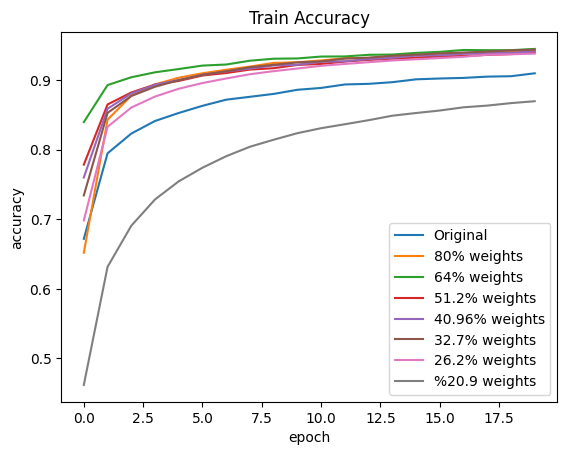

In [12]:
# Compare Train accuracies of original model and prunings
prune_rates = ['Original', '80% weights', '64% weights', '51.2% weights', '40.96% weights', '32.7% weights', '26.2% weights','%20.9 weights']


plt.plot(history1.history['accuracy'])

for h in history3:
  plt.plot(h.history['accuracy'])

plt.title('Train Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(prune_rates, loc='lower right')
plt.show()

## Plotting Validation Accuracies of Original and All Pruned Models

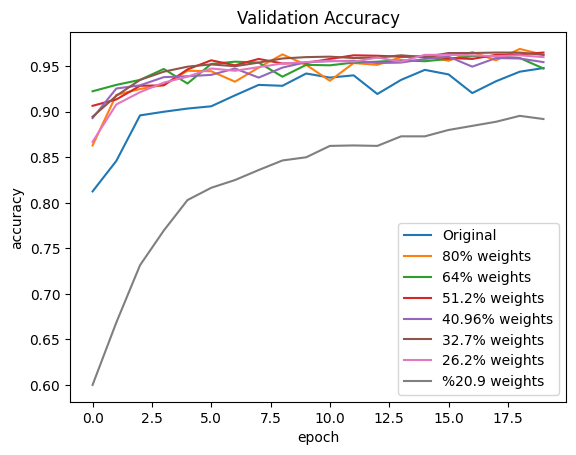

In [13]:
# Compare Validation accuracies of original model and prunings
plt.plot(history1.history['val_accuracy'])

for h in history3:
  plt.plot(h.history['val_accuracy'])

plt.title('Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(prune_rates, loc='lower right')
plt.show()

## Showing Maximum Train and Test Accuracies of Original and All Pruned Models

In [15]:
# Max train accuracies for all prune rates
print("Max train accuracies for ResNet152 network: ")
print(f"with prune rate {prune_rates[0]} : {max(history1.history['accuracy'])}")

for i in range(len(prune_rates[1:])):
   print(f"with prune rate {prune_rates[i+1]} : {max(history3[i].history['accuracy'])}")

print("\nMax test accuracies for ResNet152 network: ")
print(f"with prune rate {prune_rates[0]} : {max(history1.history['val_accuracy'])}")
# Max validation accuracies for all prune rates
for i in range(len(prune_rates[1:])):
   print(f"with prune rate {prune_rates[i+1]} : {max(history3[i].history['val_accuracy'])}")


Max train accuracies for ResNet152 network: 
with prune rate Original : 0.909465491771698
with prune rate 80% weights : 0.9418448209762573
with prune rate 64% weights : 0.9444655179977417
with prune rate 51.2% weights : 0.9393793344497681
with prune rate 40.96% weights : 0.9408620595932007
with prune rate 32.7% weights : 0.9434137940406799
with prune rate 26.2% weights : 0.9377586245536804
with prune rate %20.9 weights : 0.8693792819976807

Max test accuracies for ResNet152 network: 
with prune rate Original : 0.9480000138282776
with prune rate 80% weights : 0.968999981880188
with prune rate 64% weights : 0.9610000252723694
with prune rate 51.2% weights : 0.9649999737739563
with prune rate 40.96% weights : 0.9605000019073486
with prune rate 32.7% weights : 0.9649999737739563
with prune rate 26.2% weights : 0.9624999761581421
with prune rate %20.9 weights : 0.8955000042915344
